In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = "NBA-dataset-stats-player-team/player"

scoring = pd.read_csv(os.path.join(DATA_DIR, "player_stats_traditionnal_rs.csv"))
usage = pd.read_csv(os.path.join(DATA_DIR, "player_stats_usage_rs.csv"))
adv = pd.read_csv(os.path.join(DATA_DIR, "player_stats_advanced_rs.csv"))
players = pd.read_csv(os.path.join(DATA_DIR, "player_index.csv"))

for df in [scoring, usage, adv, players]:
    df.columns = df.columns.str.lower().str.strip().str.replace(" ", "_")

scoring.rename(columns={'reb': 'trb'}, inplace=True)

scoring = scoring[['player_id', 'season', 'pts', 'ast', 'trb']]
usage = usage[['player_id', 'season', 'usg_pct']]
adv = adv[['player_id', 'season', 'ts_pct']]

players.rename(columns={'person_id': 'player_id'}, inplace=True)
if 'player_name' not in players.columns:
    players['player_name'] = players['player_first_name'] + ' ' + players['player_last_name']
players = players[['player_id', 'player_name']]

df = scoring.merge(usage, on=['player_id', 'season'])
df = df.merge(adv, on=['player_id', 'season'])
df = df.merge(players, on='player_id')

df = df.sort_values(['player_id', 'season'])
for col in ['pts', 'ast', 'trb', 'usg_pct', 'ts_pct']:
    df[f'{col}_lag1'] = df.groupby('player_id')[col].shift(1)
    df[f'{col}_delta'] = df[col] - df[f'{col}_lag1']
df = df.dropna().reset_index(drop=True)

In [3]:
FEATURES = [f'{stat}_lag1' for stat in ['pts', 'ast', 'trb', 'usg_pct', 'ts_pct']] + \
           [f'{stat}_delta' for stat in ['pts', 'ast', 'trb', 'usg_pct', 'ts_pct']]
TARGET = 'pts'

X = df[FEATURES].values
y = df[TARGET].values
indices = df.index.values

In [4]:
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, indices, shuffle=False, test_size=0.2
)

model = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"XGBoost RMSE: {rmse:.3f}")
print(f"R^2 Score: {r2:.3f}")

results_df = pd.DataFrame({
    'player_name': df.loc[idx_test, 'player_name'].values,
    'season': df.loc[idx_test, 'season'].values,
    'actual_pts': y_test,
    'predicted_pts': y_pred
})
print(results_df.head(10))

XGBoost RMSE: 0.244
R^2 Score: 0.998
   player_name   season  actual_pts  predicted_pts
0  CJ McCollum  2017-18        21.4      21.472548
1  CJ McCollum  2018-19        21.0      20.558149
2  CJ McCollum  2019-20        22.2      21.950338
3  CJ McCollum  2020-21        23.1      23.081480
4  CJ McCollum  2021-22        22.1      22.024570
5  CJ McCollum  2022-23        20.9      20.268694
6  Cody Zeller  2014-15         7.6       7.671516
7  Cody Zeller  2015-16         8.7       8.885555
8  Cody Zeller  2016-17        10.3      10.230370
9  Cody Zeller  2017-18         7.1       7.056723


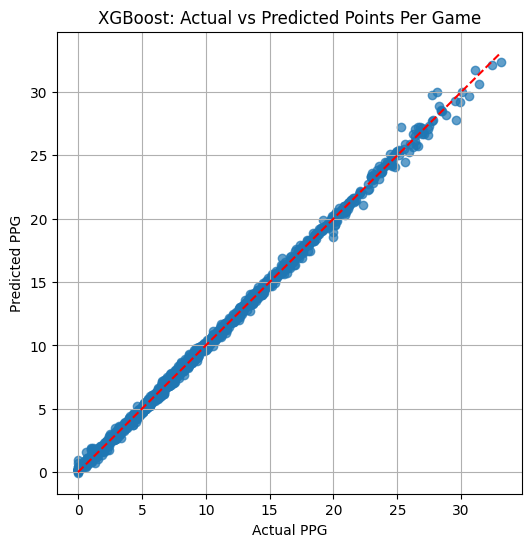

In [5]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Actual PPG")
plt.ylabel("Predicted PPG")
plt.title("XGBoost: Actual vs Predicted Points Per Game")
plt.grid(True)
plt.show()